In [1]:
import pandas as pd
import numpy as np

# Tools
import pickle
import joblib

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Comparison
from sklearn.ensemble import VotingClassifier
from imblearn.pipeline import Pipeline

# Visualizations
from xgboost import plot_importance
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('default')

Using TensorFlow backend.


In [2]:
# Load train and test sets
X_train_under = pd.read_pickle('../data/03_X_train_under.pkl')
X_test        = pd.read_pickle('../data/03_X_test.pkl')
y_train_under = pd.read_pickle('../data/03_y_train_under.pkl')
y_test        = pd.read_pickle('../data/03_y_test.pkl')

In [3]:
# load models from disk
lgr_best = joblib.load('../models/lgr_best.sav')
knn_best = joblib.load('../models/knn_best.sav')
rfc_best = joblib.load('../models/rfc_best.sav')
xgb_best = joblib.load('../models/xgb_best.sav')

# result = xgb_best.score(X_test, y_test)
# print(result)

# Model comparison

In [4]:
# Load pickle
with open('../data/04_model_performance.pkl', 'rb') as f:
    model_performance = pickle.load(f)
    f.close()

In [5]:
model_performance_df = pd.DataFrame(data=model_performance)
model_performance_df = model_performance_df[['Model', 'ROC AUC', 'Precision', 'Recall', 'F1']]
model_performance_df.sort_values(by='F1', ascending=False).reset_index(drop=True)

,Model,ROC AUC,Precision,Recall,F1
0,XGBoost,0.824,0.576,0.807,0.672
1,Logistic Regression,0.741,0.432,0.741,0.546
2,KNN,0.743,0.424,0.761,0.544
3,Random Forest,0.702,0.354,0.784,0.488


# Confusion Matrix

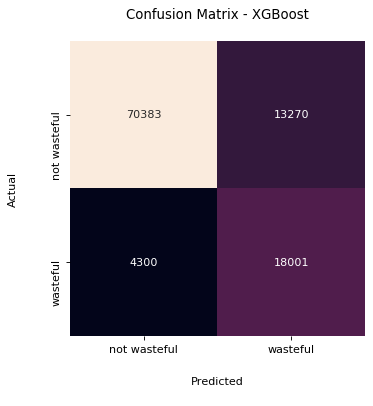

In [6]:
# Load pickle
with open('../data/04_xgb_best_preds.pkl', 'rb') as f:
    xgb_best_preds = pickle.load(f)
    f.close()

# Print confusion matrix for XGBoost
xgb_confusion = confusion_matrix(y_test, xgb_best_preds)

plt.figure(dpi=80)
sns.heatmap(xgb_confusion, annot=True, fmt='g', square=True, cbar=False,
            xticklabels=['not wasteful', 'wasteful'],
            yticklabels=['not wasteful', 'wasteful'])

plt.title('Confusion Matrix - XGBoost', pad=20)
plt.xlabel('Predicted\n', labelpad=20)
plt.ylabel('Actual\n', labelpad=20);

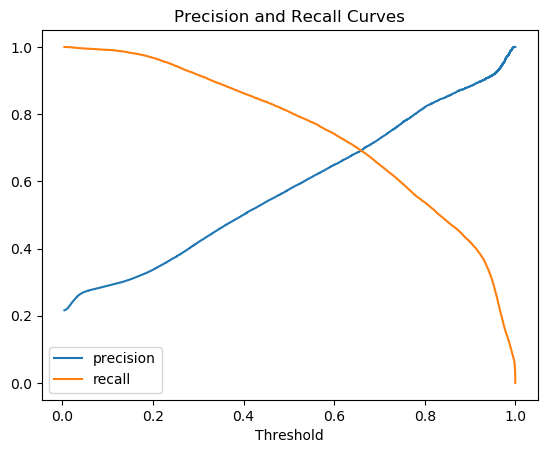

In [7]:
# Precision & Recall curves
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, xgb_best.predict_proba(X_test)[:,1])

plt.figure(dpi=100)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

In [8]:
# F1 score, default threshold
round(f1_score(y_test.values, xgb_best_preds), 3)

0.672

In [9]:
# Tune threshold value for optimal f1 score
threshold_scores = {}
for t in np.linspace(0.1, 1, 10):
    y_pred = xgb_best.predict_proba(X_test)[:, 1] > t
    threshold_scores[t] = round(f1_score(y_test.values, y_pred), 3)
    
print(threshold_scores)

{0.1: 0.447, 0.2: 0.5, 0.30000000000000004: 0.575, 0.4: 0.634, 0.5: 0.672, 0.6: 0.692, 0.7000000000000001: 0.686, 0.8: 0.649, 0.9: 0.569, 1.0: 0.0}


The optimal threshold value is  0.6


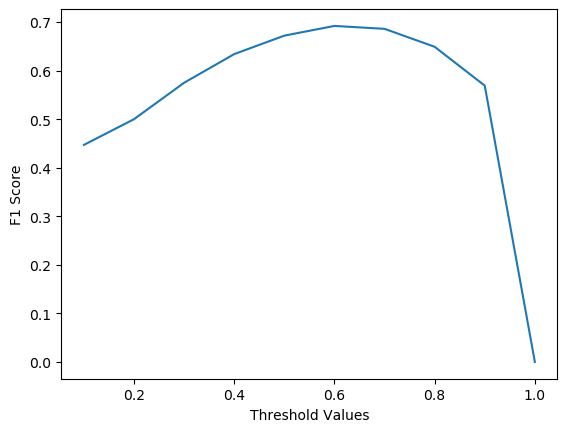

In [10]:
# Find best threshold
keys = list(threshold_scores.keys())
values = list(threshold_scores.values())
threshold = keys[values.index(max(values))]

# Plot F1 scores
print('The optimal threshold value is ', threshold)
plt.plot(keys, values)
plt.xlabel('Threshold Values')
plt.ylabel('F1 Score');

Optimal threshold for XGBoost model is **.6** with an F1 Score of **.7**

In [11]:
# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, xgb_best_preds)))


Confusion Matrix
[[70383 13270]
 [ 4300 18001]]


# Feature Importance

Text(0.5, 1.0, 'Feature Importance')

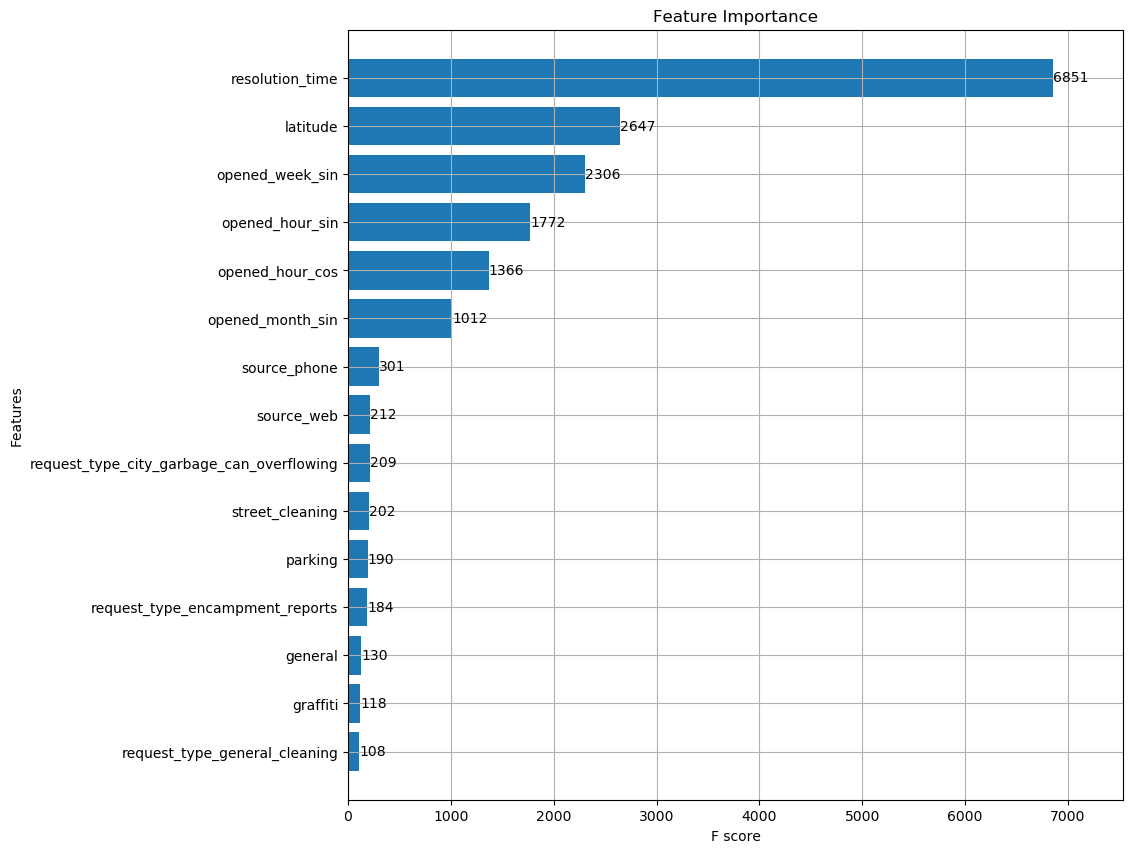

In [13]:
# Feature Importance – XGBoost
fig, ax = plt.subplots(figsize=(10,10))
# xgb_best.get_booster().feature_names = list(X_test.columns)
plot_importance(xgb_best.get_booster(), max_num_features=15, height=0.8, ax=ax)
plt.title('Feature Importance')

# import matplotlib.pylab as pl
# plot_importance(xgb_best.get_booster(), max_num_features=15)
# plt.title("xgboost.plot_importance(model)")
# plt.show()

# Appendix

## Shap

In [ ]:
# # Load pickle
# with open('../data/03_X.pkl', 'rb') as f:
#     X = pickle.load(f)
#     f.close()

In [ ]:
# import shap

# # this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
# explainer = shap.TreeExplainer(xgb_best)
# shap_values = explainer.shap_values(X)

In [ ]:
# # Visualize a single prediction
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

### Mean of Importance
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

In [ ]:
# shap.summary_plot(shap_values, X_display, plot_type="bar")

In [ ]:
# shap.summary_plot(shap_values, X)